In [2]:
# Cell 1: Upload ZIP Folder
# Run this cell first to upload and extract your data
from google.colab import files
import zipfile

print("Select the landform_images.zip file to upload:")
uploaded = files.upload()
for fn in uploaded:
    if fn.endswith('.zip'):
        print(f"Unzipping {fn}...")
        with zipfile.ZipFile(fn, 'r') as zip_ref:
            zip_ref.extractall('/content/landform_images')
        print("Extraction complete to /content/landform_images")

# After extraction, proceed to the next cell.

Select the landform_images.zip file to upload:


Saving landform_images.zip to landform_images.zip
Unzipping landform_images.zip...
Extraction complete to /content/landform_images


In [3]:
# --- CELL 2: Install Dependencies & Imports ---

!pip install tensorflow matplotlib opencv-python

# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.preprocessing import image_dataset_from_directory



In [12]:
# Cell 3: Configuration and Data Loading
IMG_SIZE = 224
BATCH_SIZE = 32
# Detect extracted subfolder if nested
base_dir = '/content/landform_images'
subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
if len(subdirs) == 1:
    DATA_DIR = os.path.join(base_dir, subdirs[0])
    print(f"Using DATA_DIR = {DATA_DIR}")
else:
    DATA_DIR = base_dir
    print(f"Using DATA_DIR = {DATA_DIR}")

VALIDATION_SPLIT = 0.2
SEED = 123
EPOCHS = 5
LAST_CONV_LAYER = 'block_16_project'

# Remove corrupted images before loading dataset
from PIL import Image
import glob
for class_name in os.listdir(DATA_DIR):
    class_dir = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_dir):
        for img_file in glob.glob(os.path.join(class_dir, '*')):
            try:
                Image.open(img_file).verify()
            except Exception:
                print(f"Deleting corrupted image: {img_file}")
                os.remove(img_file)

# Load datasets with automated split (no manual class_names needed)
train_ds = image_dataset_from_directory(
    DATA_DIR,
    labels='inferred', label_mode='categorical',
    validation_split=VALIDATION_SPLIT,
    subset='training',
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_ds = image_dataset_from_directory(
    DATA_DIR,
    labels='inferred', label_mode='categorical',
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)
# Dynamically retrieve class names
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
print("Detected classes:", CLASS_NAMES)

# Prefetch for performance and ignore errors
tf_ds = tf.data
train_ds = train_ds.prefetch(tf_ds.AUTOTUNE).apply(tf_ds.experimental.ignore_errors())
val_ds = val_ds.prefetch(tf_ds.AUTOTUNE).apply(tf_ds.experimental.ignore_errors())

# Keep raw dataset before preprocessing for visualization
raw_train_ds = train_ds
raw_val_ds = val_ds

# Preprocessing: convert to MobileNetV2 input format
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
train_ds = raw_train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = raw_val_ds.map(lambda x, y: (preprocess_input(x), y))

Using DATA_DIR = /content/landform_images/landform_images
Found 822 files belonging to 5 classes.
Using 658 files for training.
Found 822 files belonging to 5 classes.
Using 164 files for validation.
Detected classes: ['Fan', 'Landslide', 'Rock_cliff', 'Scree_deposit', 'Stable_slope']


In [13]:
# Cell 4: Build and Train Model# Cell 4: Build and Train Model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5486 - loss: 1.2036 - val_accuracy: 0.8720 - val_loss: 0.3747
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8627 - loss: 0.4128 - val_accuracy: 0.9390 - val_loss: 0.2289
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9290 - loss: 0.2385 - val_accuracy: 0.9817 - val_loss: 0.0899
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9687 - loss: 0.1582 - val_accuracy: 0.9817 - val_loss: 0.0724
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9675 - loss: 0.1343 - val_accuracy: 0.9878 - val_loss: 0.0612


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 571ms/step


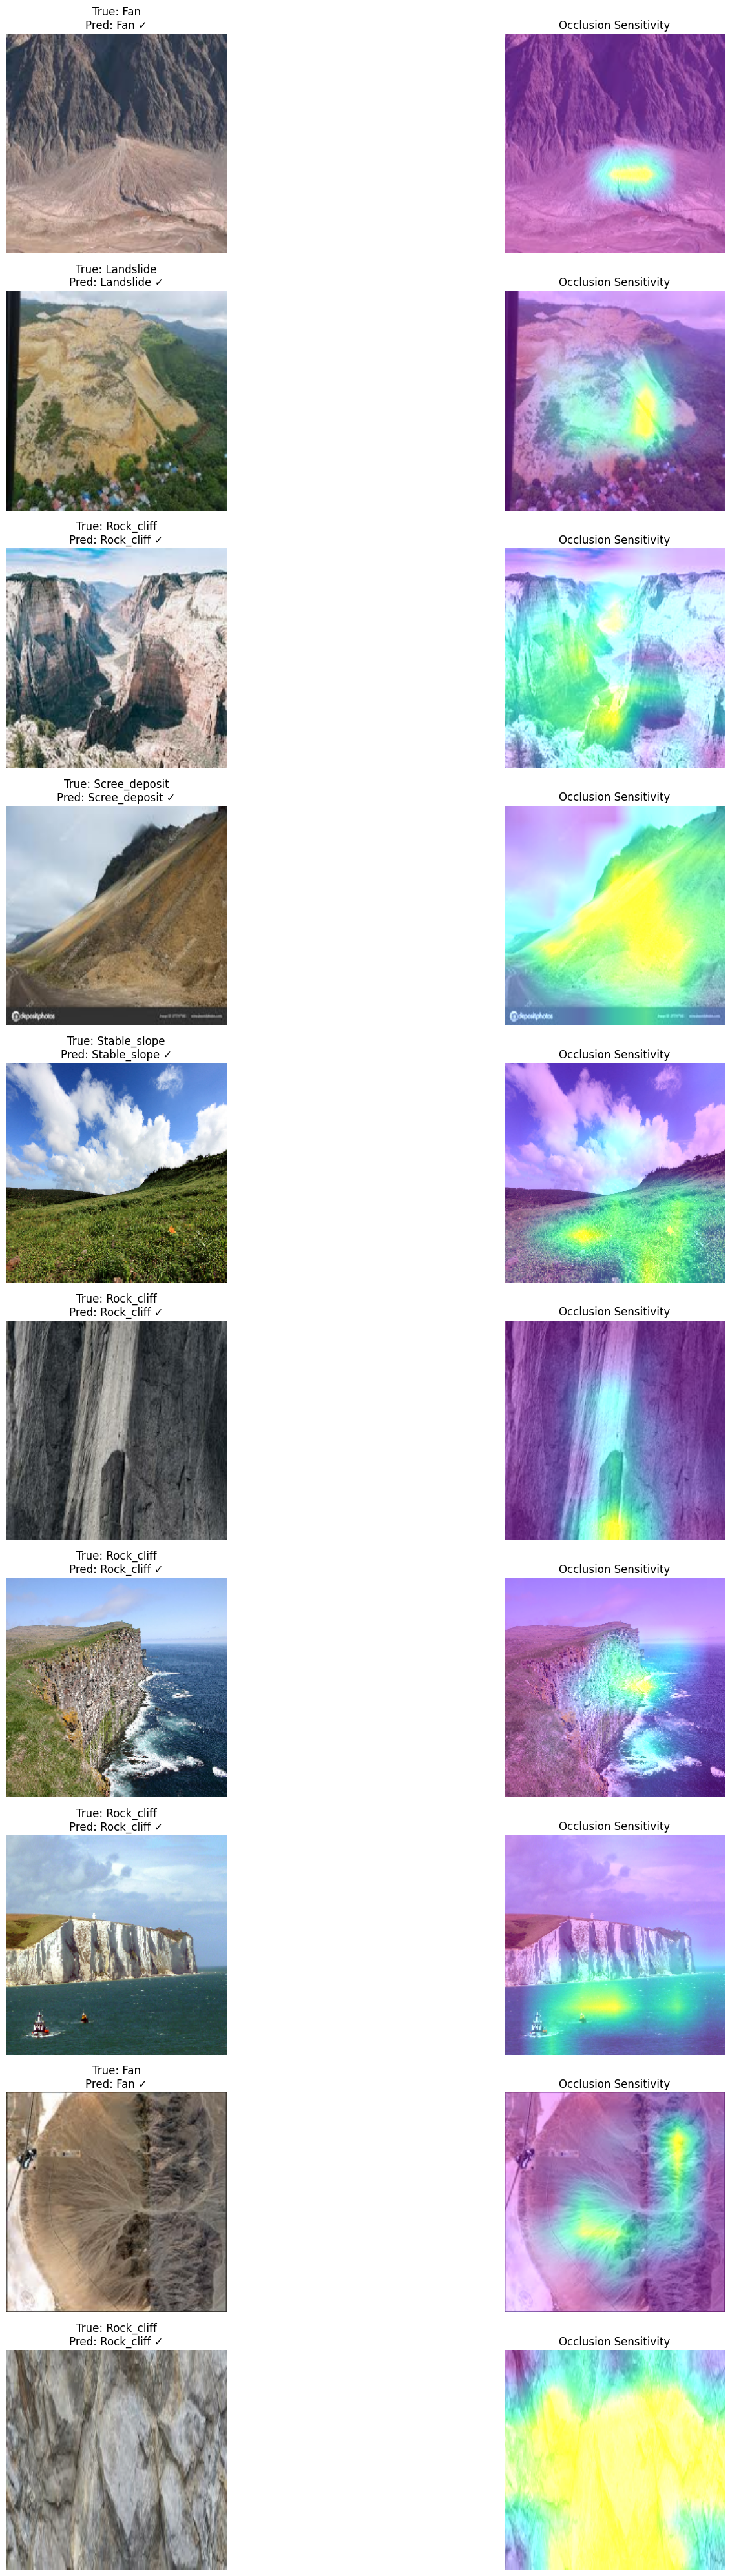

In [22]:
# Cell 5: Occlusion Sensitivity XAI Visualization
!pip install -q tf-explain

import numpy as np
import matplotlib.pyplot as plt
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
import random
import tensorflow as tf

# Initialize the occlusion sensitivity explainer
explainer = OcclusionSensitivity()

# 1) Collect a balanced set of 10 examples from the raw training dataset by index
raw_all_data = list(raw_train_ds.unbatch().take(5000))
# Map each class to one index
by_class_idx = {i: None for i in range(NUM_CLASSES)}
for idx, (img, label) in enumerate(raw_all_data):
    cls = int(tf.argmax(label))
    if by_class_idx[cls] is None:
        by_class_idx[cls] = idx
# Initial sample indices ensuring one per class
sample_indices = [idx for idx in by_class_idx.values() if idx is not None]
# Fill remaining slots randomly (avoid duplicates)
remaining_indices = [i for i in range(len(raw_all_data)) if i not in sample_indices]
random.shuffle(remaining_indices)
needed = 10 - len(sample_indices)
sample_indices += remaining_indices[:needed]
# Ensure exactly 10 unique samples
sample_indices = sample_indices[:10]
# Gather the actual (raw_img, label) pairs (raw_img, label) pairs
samples = [raw_all_data[i] for i in sample_indices]

# 2) Visualize each with occlusion sensitivity
plt.figure(figsize=(20, 40))
for idx, (raw_img, label) in enumerate(samples):
    # raw_img is in [0,255], shape (H,W,3)
    # Create preprocessed input for the model
    proc_input = preprocess_input(tf.expand_dims(raw_img, axis=0))

    # Predict class index
    preds = model.predict(proc_input)
    pred_index = int(np.argmax(preds[0]))
    true_index = int(tf.argmax(label))
    true_name = CLASS_NAMES[true_index]
    pred_name = CLASS_NAMES[pred_index]
    correct = '✓' if pred_index == true_index else '✗'

    # Compute occlusion sensitivity map on preprocessed input
    grid = explainer.explain(
        (proc_input.numpy(), None),
        model,
        class_index=pred_index,
        patch_size=32
    )

    # Plot raw original image with labels and correctness
    plt.subplot(10, 2, 2 * idx + 1)
    plt.imshow(raw_img.numpy().astype('uint8'))
    plt.title(f"True: {true_name}\nPred: {pred_name} {correct}")

    plt.axis('off')

    # Plot sensitivity map (grid) over raw image
    plt.subplot(10, 2, 2 * idx + 2)
    plt.imshow(grid)
    plt.title(f"Occlusion Sensitivity")
    plt.axis('off')

plt.tight_layout()
plt.show()
plt.show()
